In [12]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline
import matplotlib.image as mpimg
from collections import deque
import pickle
import os

### Camera Calibration

In [13]:
def calibrate_camera(calib_images, calib_data):
    #Calibration data
    cbrow = 6
    cbcol = 9

    objp = np.zeros((cbrow*cbcol,3), np.float32)
    objp[:,:2] = np.mgrid[0:cbcol, 0:cbrow].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    #images = glob.glob('camera_cal/calibration*.jpg')
    images = glob.glob(calib_images)
    
    # Search for chessboard corners

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (cbcol,cbrow), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    #pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
    pickle.dump( dist_pickle, open( calib_data, "wb" ) )
    
    return mtx, dist

In [14]:
from pathlib import Path

calib_images= 'camera_cal/calibration*.jpg'
calib_data='camera_cal/wide_dist_pickle.p'

if Path(calib_data).is_file():
    print('Calibration data loaded...')
    dist_pickle= pickle.load( open( calib_data, "rb" ) )
    mtx= dist_pickle["mtx"]
    dist= dist_pickle["dist"]
else:
    mtx,dist= calibrate_camera(calib_images, calib_data)

Calibration data loaded...


### Undistort image

In [15]:
def undistort(img):
    img_undis = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undis

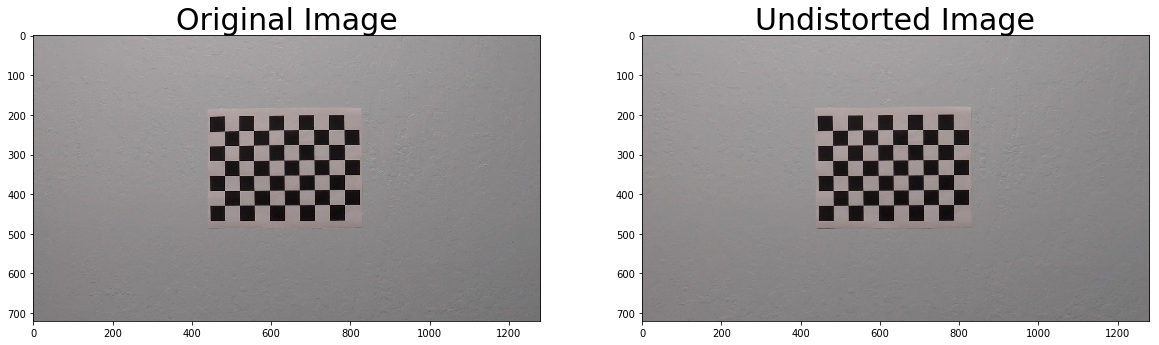

In [16]:
import pickle
%matplotlib inline

images = glob.glob(calib_images)
# Test undistortion on an image
i= np.random.randint(len(images))
file= images[i]
img = cv2.imread(file)

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#dst = cv2.undistort(img, mtx, dist, None, mtx)
dst = undistort(img)
#cv2.imwrite('camera_cal/test_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Bird eye view

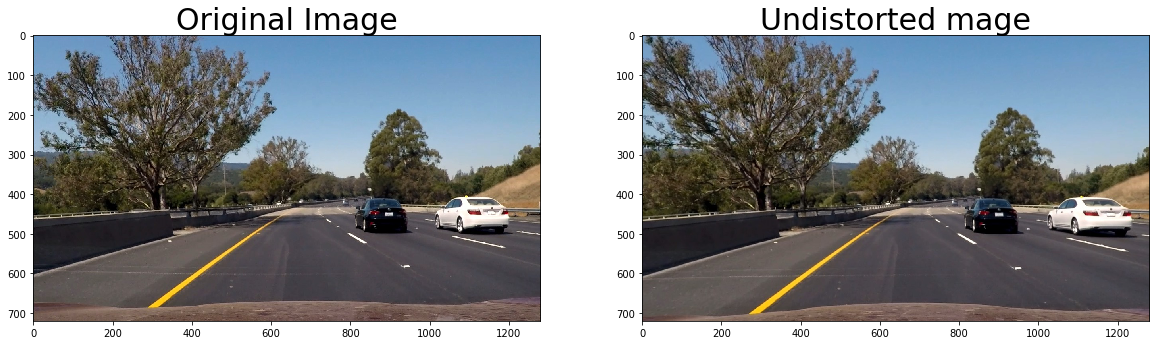

In [17]:
file='test_images/test6.jpg'
img= cv2.imread(file)

undis = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#cv2.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(undis, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted mage', fontsize=30)

In [18]:
def bird_eye_view_matrix(src,des):
    
    #Perspective matrix
    A = cv2.getPerspectiveTransform(src, des)
    #inverse perspective matrix
    Ainv = cv2.getPerspectiveTransform(des, src)
    
    return A,Ainv

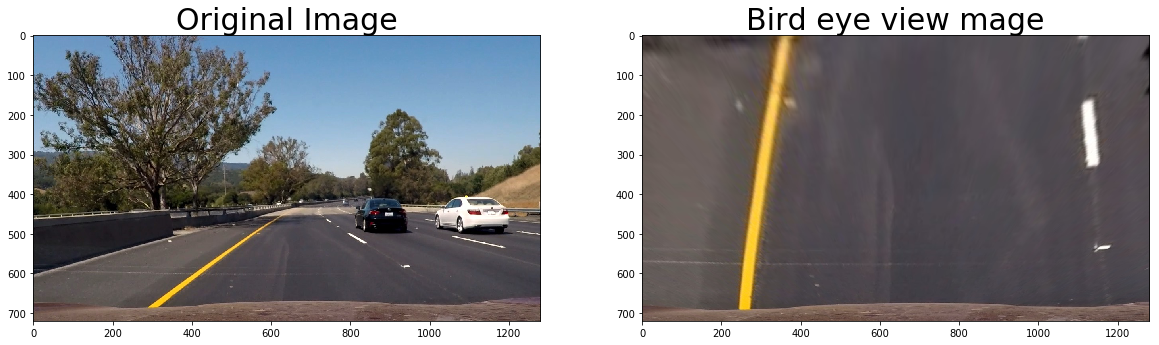

In [19]:

src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
des = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])

#Compute bird eye view matrix
A,Ainv= bird_eye_view_matrix(src,des)

file='test_images/test6.jpg'
img= cv2.imread(file)


binary_warped = cv2.warpPerspective(img, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

#cv2.imwrite('test_images/test6_warp.jpg',binary_warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#cv2.imshow(img)
ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(binary_warped, cmap='gray')
ax2.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Bird eye view mage', fontsize=30)

### Color thresholds

In [20]:
def color_thresholds_BGR(img): 
    #input BGR image
    #with this function we compute a binary image from thresholding a color image
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary

In [21]:
def color_thresholds_RGB(img):
    #input RGB image
    #with this function we compute a binary image from thresholding a color image

    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   

    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary

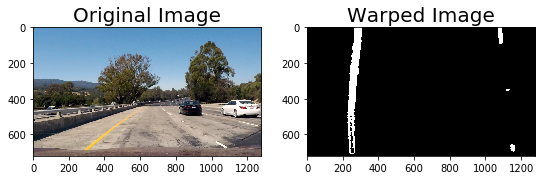

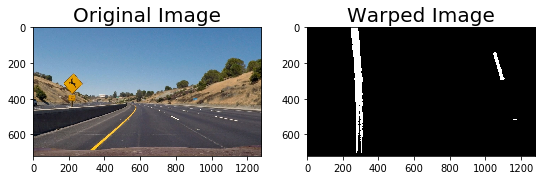

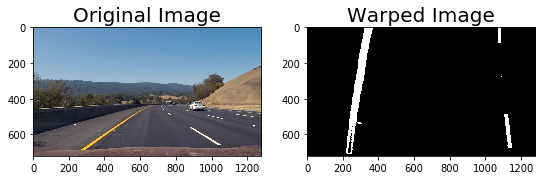

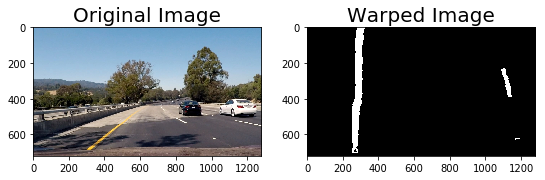

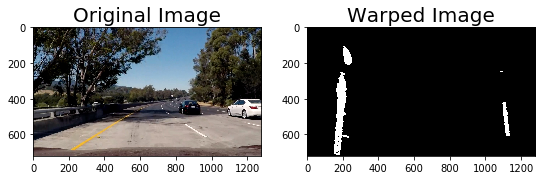

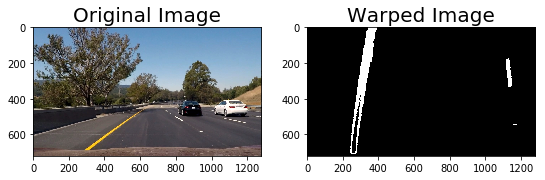

In [22]:
for file in glob.glob('test_images/test*.jpg'):
    img= cv2.imread(file)
    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    warped_th=color_thresholds_BGR(warped)
    
    filename, file_extension = os.path.splitext(file)
    #print(file_extension)
    #cv2.imwrite(filename + '_warp_th'+file_extension,warped_th)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Warped Image', fontsize=20)
    ax2.imshow(warped_th,cmap='gray')
    

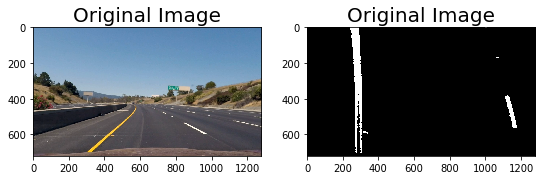

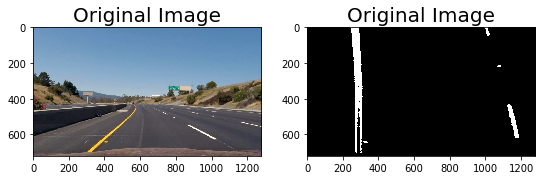

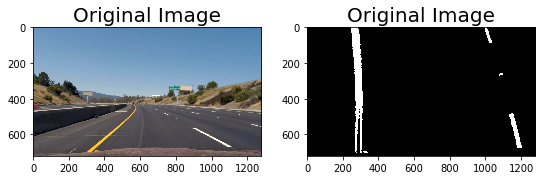

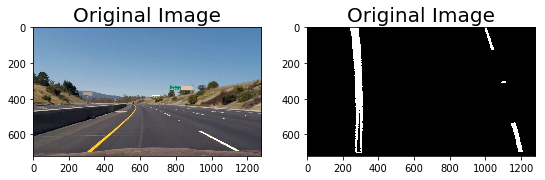

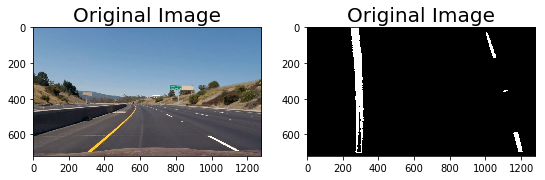

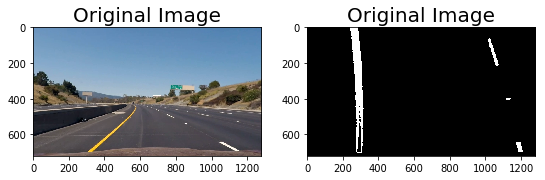

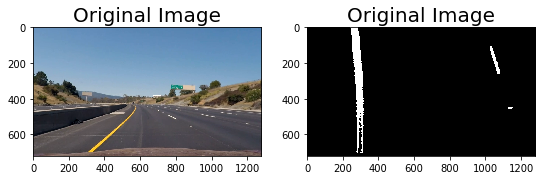

In [23]:
#Here we test the thresholding function with the first five video frames

vc = cv2.VideoCapture('project_video.mp4')
rval=True
i=0    
while rval:
    rval, img = vc.read()

    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    warped_th=color_thresholds_BGR(warped)
    
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Original Image', fontsize=20)
    ax2.imshow(warped_th, cmap='gray')

    if i>5:
        break
    i=i+1

### Line detection using histogram

In [24]:
def line_find(img):
    #Line detection using the histogram of the bottom half of the image
    
    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    binary_warped=color_thresholds_BGR(warped)

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fit, right_fit

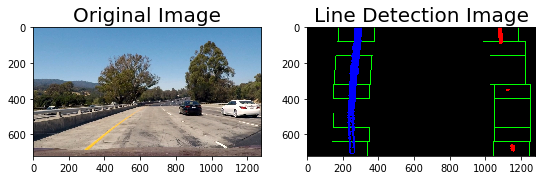

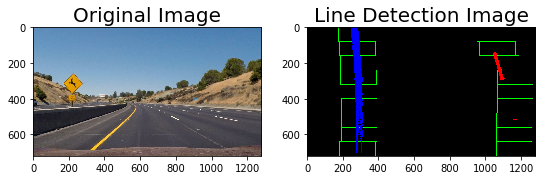

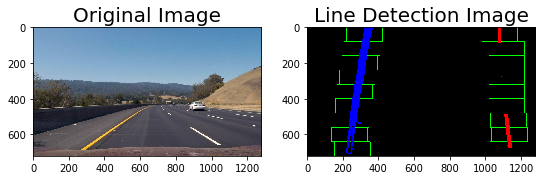

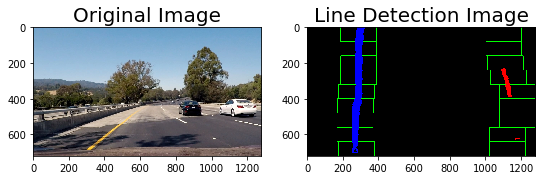

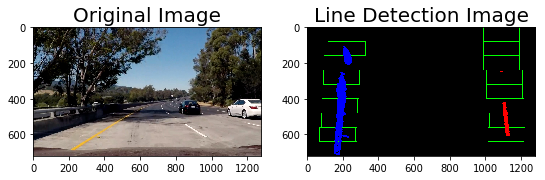

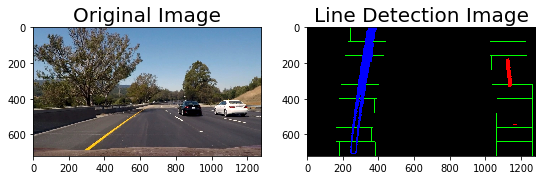

In [25]:
for file in glob.glob('test_images/test*.jpg'):
    img= cv2.imread(file)
    #result=find_line(img)
    result, left_fit, right_fit=line_find(img)

    #print(result.shape)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Line Detection Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    #ax2.imshow(result,cmap='gray')

### Line tracking

In [26]:
def line_tracking(img, left_fit, right_fit):
    #Uses the information of the previous frame to track the line
   
    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    binary_warped=color_thresholds_BGR(warped)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,left_fit, right_fit, left_fitx, right_fitx, ploty
    
    

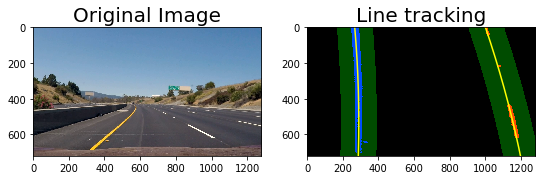

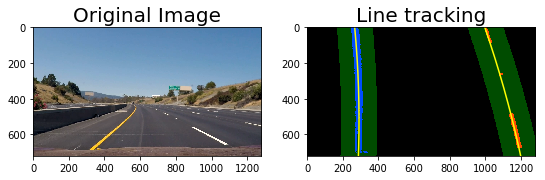

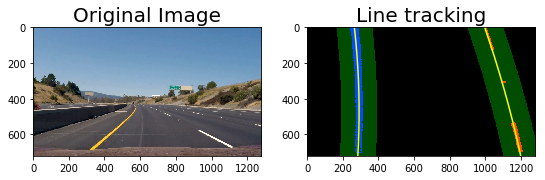

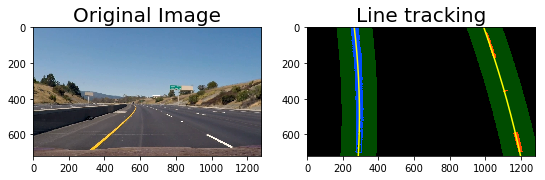

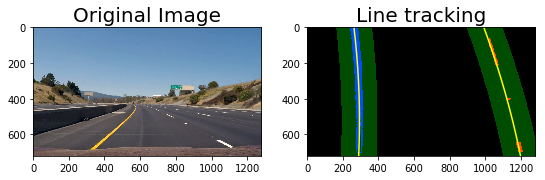

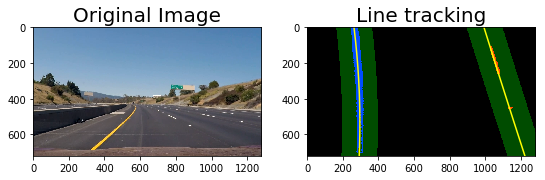

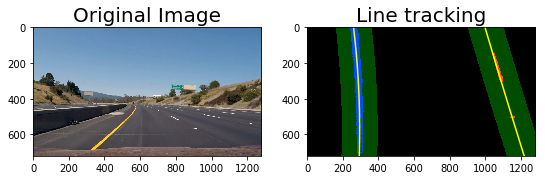

In [27]:
vc = cv2.VideoCapture('project_video.mp4')
rval, img = vc.read()

result, left_fit, right_fit= line_find(img)
i=0    
while rval:
    rval, img = vc.read()
    result,left_fit, right_fit, left_fitx, right_fitx, ploty=line_tracking(img,left_fit,right_fit)
    

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Line tracking', fontsize=20)
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    if i>5:
        break
    i=i+1

In [28]:
def draw_results(image, left_fitx, right_fitx, ploty):
    #Plot the results in the undistorted image

    undist = undistort(image)
    warped0 = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    warped = cv2.cvtColor(warped0, cv2.COLOR_BGR2GRAY)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Ainv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

### Draw results

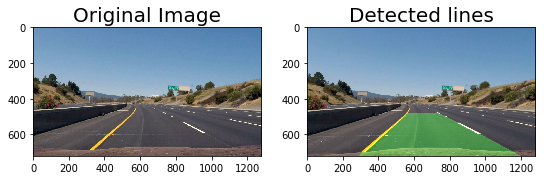

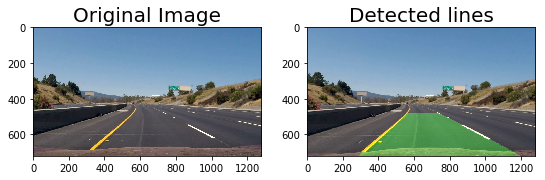

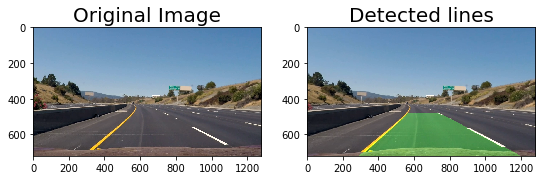

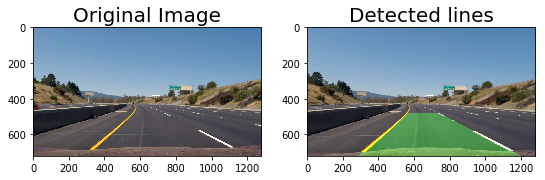

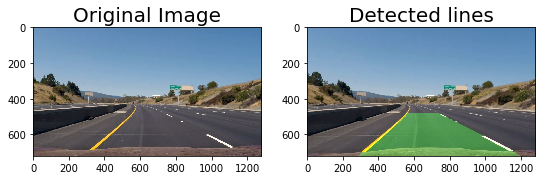

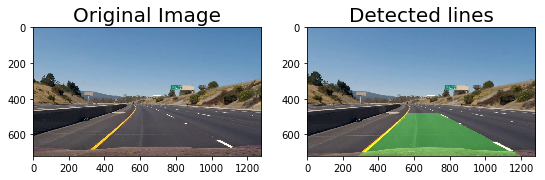

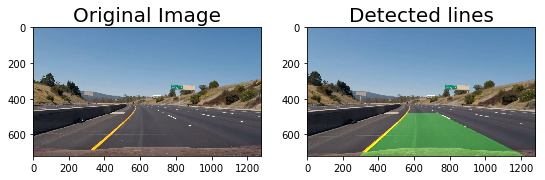

In [29]:
vc = cv2.VideoCapture('project_video.mp4')
rval= True

i=0    
while rval:
    rval, img = vc.read()

    #result,left_fit, right_fit= line_tracking(img,left_fit,right_fit)
    result0,left_fit, right_fit, left_fitx, right_fitx, ploty=line_tracking(img,left_fit,right_fit)
    
    result= draw_results(img, left_fitx, right_fitx, ploty)
    #print(rval)
    #cv2.imshow('image',frame)
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Detected lines', fontsize=20)
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

    if i>5:
        break
    i=i+1

# Video processing

### Line class definition

In [30]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.fit= None
        self.fitx= None
        
        self.fits= deque(maxlen=10)
        
        self.curverad= None



In [39]:
def find_lines(binary_warped):
    #This function finds the lines in the image using the histogram on the bottom half of the image
    #The important information is saved in the Left and Right objects

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    Left.detected= len(leftx) > 0 and len(lefty) > 0
    Right.detected= len(rightx) > 0 and len(righty) > 0
    
    if Left.detected:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        Left.fits.append(left_fit)
    else:
        left_fit= np.mean(Left.fits,axis=0)
    
    if Right.detected:
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)    
        Right.fits.append(right_fit)
    else:
        right_fit= np.mean(Right.fits,axis=0)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    Left.fit= left_fit
    Right.fit= right_fit

    Left.fitx= left_fitx
    Right.fitx= right_fitx
    
    y_eval = binary_warped.shape[0]
    ym_per_pix = 15/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    Left.curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    Right.curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return out_img, ploty

In [40]:
def track_line(img, binary_warped):
    #This function tracks the Left and Right images
    #if the lines are not found then the find_lines will be used in the video processing
    #the function uses the mean of the 10 previous line coefficients to obtain better results

    left_fit= Left.fit
    right_fit= Right.fit
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    Left.detected= len(leftx) > 0 and len(lefty) > 0
    Right.detected= len(rightx) > 0 and len(righty) > 0
    
    if Left.detected:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        Left.fits.append(left_fit)
    
    if Right.detected:
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)    
        Right.fits.append(right_fit)
        
    left_fit= np.mean(Left.fits,axis=0)
    right_fit= np.mean(Right.fits,axis=0)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
 
    #print('hola')
    Left.fit= left_fit
    Right.fit= right_fit

    Left.fitx= left_fitx
    Right.fitx= right_fitx
    
    y_eval = binary_warped.shape[0]
 
    ym_per_pix = 15/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


    # Calculate the new radii of curvature
    Left.curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    Right.curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #return result,left_fit, right_fit, left_fitx, right_fitx, ploty
    return result, ploty

In [42]:
def plot_values(result):
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    cv2.putText(result, 'Curvature: Left={:.0f} m, Right={:.0f} m'.format(Left.curverad, Right.curverad), (50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=1, color=(255,255,255), thickness=2)
    
    position = (Left.fitx[-1] + Right.fitx[-1])/2
    center = img.shape[1]/2
    
    dx = (position - center)*xm_per_pix
    
    if dx <0:
        text='left'
    else:
        text= 'right'
        
    cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dx), text),(50,110), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return result
    

In [34]:
def process_video(img):
    #this is the main video processing function
    
    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    binary_warped=color_thresholds_RGB(warped)

    #If the left and right cameras were found, then it uses previous information to track them
    if Left.detected == True and Right.detected == True:
        result, ploty= track_line(img, binary_warped)
    
    #if the lines are not found then it uses the histogram to search them
    if Left.detected == False or Right.detected == False:
        result, ploty=find_lines(binary_warped)
    
    result= draw_results(img, Left.fitx, Right.fitx, ploty)
    
    result= plot_values(result)

    return result


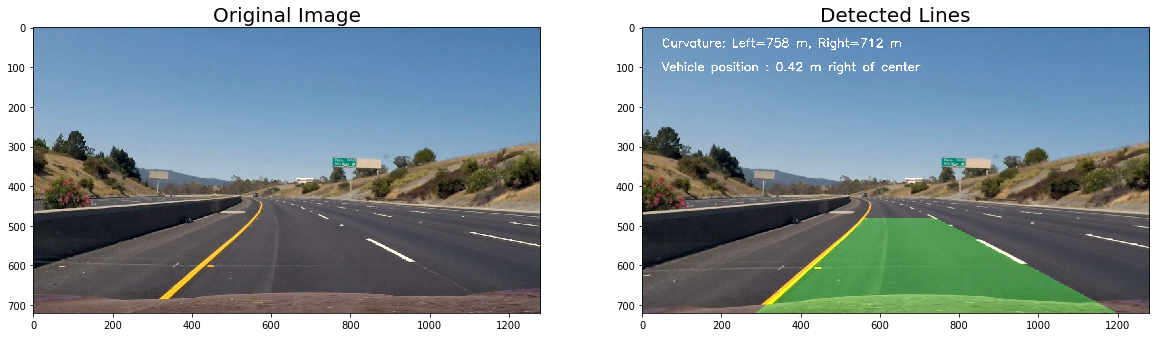

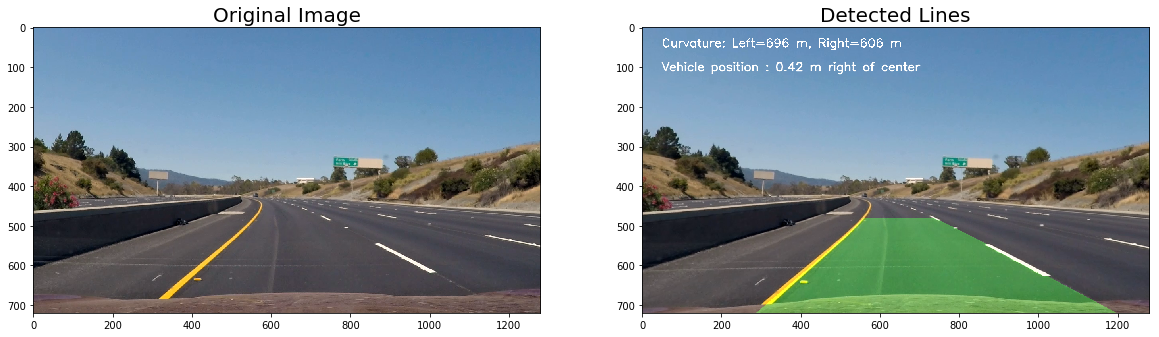

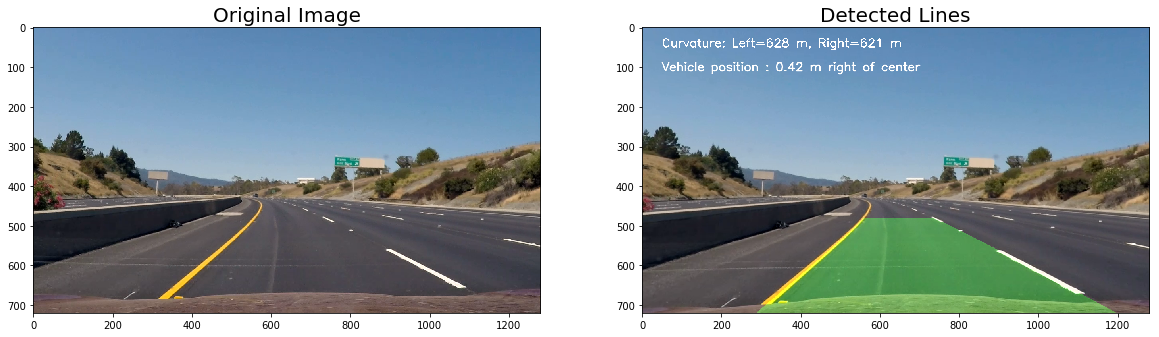

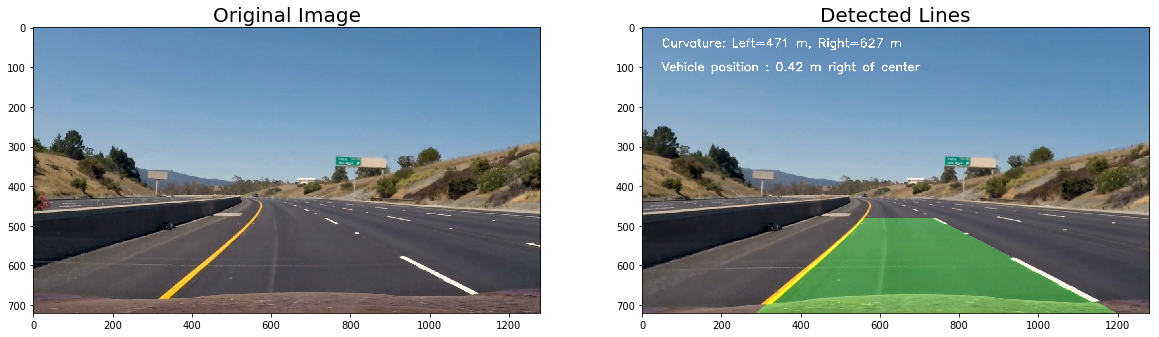

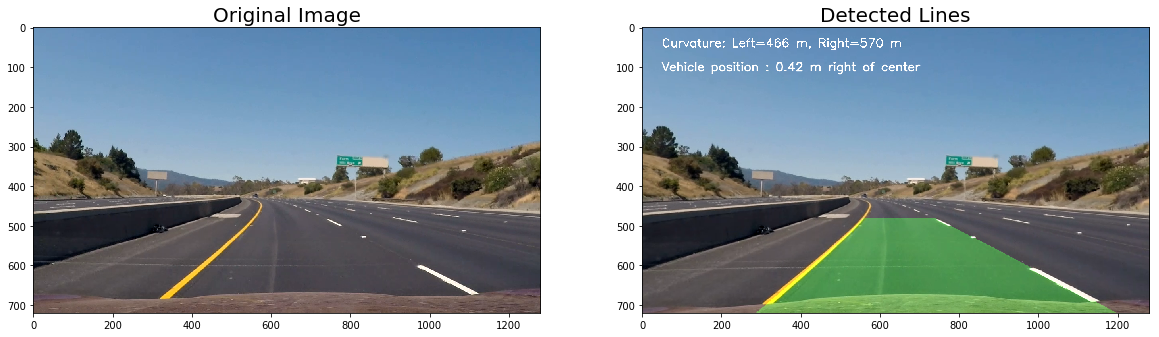

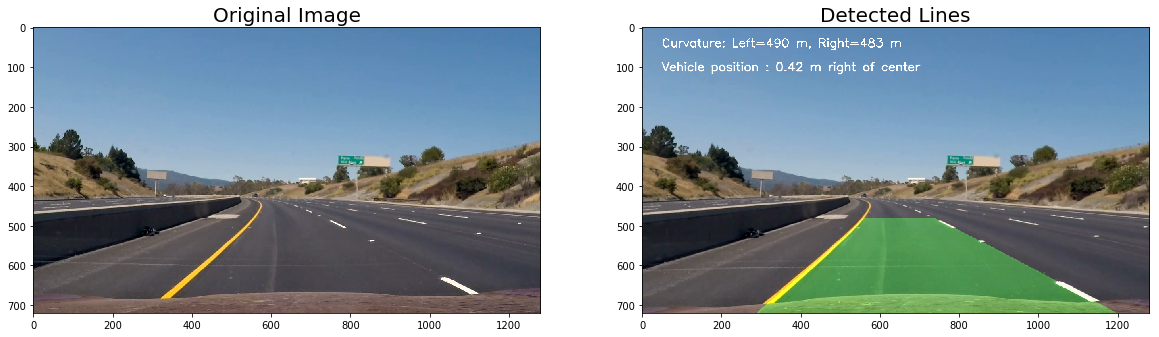

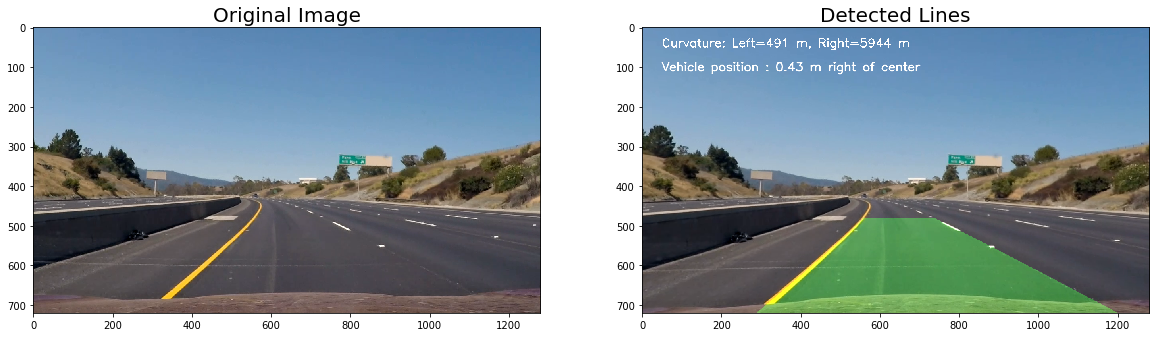

In [43]:
Left=Line()
Right=Line()

vc = cv2.VideoCapture('project_video.mp4')

rval= True
i=0    
while rval:
    rval, img = vc.read()
    
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result= process_video(img)

    #f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(img)
    ax2.set_title('Detected Lines', fontsize=20)
    ax2.imshow(result)

    #f, (ax1) = plt.subplots(1, 2, figsize=(9,6))
    #ax1.set_title('Detected Lines', fontsize=20)
    #ax1.imshow(result)


    if i>5:
        break
    i=i+1

In [44]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [45]:
Left = Line()
Right = Line()
video_output = 'video_result.mp4'
count=0
#clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video video_result.mp4
[MoviePy] Writing video video_result.mp4


100%|█████████▉| 1260/1261 [02:59<00:00,  7.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_result.mp4 

